# huggingface + WRIMEデータセット で感情推定

## 環境構築

In [1]:
# huggingface transformer のインストール
# - transformers : 主たるモジュール（モデルやトークナイザのダウンロード)
# - datasets : HuggingFaceで、データセットを扱うためのモジュール
# https://huggingface.co/docs/transformers/installation
! pip install transformers datasets

# 東北大学の日本語用BERT使用に必要なパッケージをインストール
! pip install fugashi ipadic

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import pandas as pd

In [3]:
# Hugging Face (Transformers) 関連のモジュール
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from datasets import Dataset, load_metric

### Matplotlibで日本語を使用できるようにする

In [4]:
# [前準備] Matplotlib で日本語フォントを使用できるようにする
# cf. https://blog.3qe.us/entry/2018/08/16/121457
!apt-get -y install fonts-ipafont-gothic
!rm /root/.cache/matplotlib/fontlist-v310.json

# NOTE ここで、ランタイムを再起動

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-ipafont-gothic is already the newest version (00303-18ubuntu1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.


Text(0.5, 1.0, '日本語を表示できるかテスト')

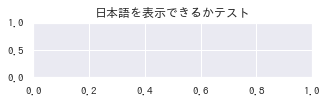

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font='IPAGothic')

# 動作確認
plt.figure(figsize=(5,1))
plt.title('日本語を表示できるかテスト')

## データセットの準備

### WRIMEデータセットのダウンロード

In [6]:
# GitHubよりWRIMEデータをダウンロードする
# 
# WRIME dataset : https://github.com/ids-cv/wrime
# 今回使用するのは ver1 （感情極性が付与されていない版）
! wget https://github.com/ids-cv/wrime/raw/master/wrime-ver1.tsv

--2022-08-31 03:03:46--  https://github.com/ids-cv/wrime/raw/master/wrime-ver1.tsv
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ids-cv/wrime/master/wrime-ver1.tsv [following]
--2022-08-31 03:03:46--  https://raw.githubusercontent.com/ids-cv/wrime/master/wrime-ver1.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9487237 (9.0M) [text/plain]
Saving to: ‘wrime-ver1.tsv.1’

wrime-ver1.tsv.1    100%[===================>]   9.05M  --.-KB/s    in 0.03s   

2022-08-31 03:03:48 (332 MB/s) - ‘wrime-ver1.tsv.1’ saved [9487237/9487237]



In [7]:
# pandas.DataFrameとして読み込む
df_wrime = pd.read_table('wrime-ver1.tsv')
df_wrime.head(2)

,Sentence,UserID,Datetime,Train/Dev/Test,Writer_Joy,Writer_Sadness,Writer_Anticipation,Writer_Surprise,Writer_Anger,Writer_Fear,...,Reader3_Disgust,Reader3_Trust,Avg. Readers_Joy,Avg. Readers_Sadness,Avg. Readers_Anticipation,Avg. Readers_Surprise,Avg. Readers_Anger,Avg. Readers_Fear,Avg. Readers_Disgust,Avg. Readers_Trust
0,ぼけっとしてたらこんな時間｡チャリあるから食べにでたいのに…,1,2012/07/31 23:48,train,0,1,2,1,1,0,...,1,0,0,2,0,0,0,0,0,0
1,今日の月も白くて明るい。昨日より雲が少なくてキレイな? と立ち止まる帰り道｡チャリなし生活も...,1,2012/08/02 23:09,train,3,0,3,0,0,0,...,0,1,1,0,0,2,0,0,0,0


### 前処理

__前提①：WRIMEデータセットのラベルは、各感情の強度__ 
- 各感情（例えば、Joy=喜）の強度を、0〜3の４段階でラベル付けしている
- ８つの感情全てにおいて、最頻ラベルは「0」


__前提②：WRIMEデータセットには、複数種類のラベルが付与されている__
1. Writer_*
    - 文章の __書き手__ が自身で付与したラベル。「主観感情」。
2. Reader{1,2,3}_* :
    - 文章の __読み手__ が付与したラベル。「客観感情」。３名分。
3. Avg.Readers_*
    - ３名分の客観感情の平均値。

問題設定
1. ８つの感情の、分類タスクとして扱う
    - 相対的にどの感情が強いかを推定する
    - データセットの本来の用途としては感情強度を推定するタスク。しかしながら、感情強度=0のサンプルが多く、やや扱いが難しいため、今回は簡素化して扱う。
2. 客観感情の平均値を使用する
    - 論文において、主観感情と客観感情は異なることが指摘されている
    - 主観感情は、書き手の性格や表現方法に依存する部分がある。そのため、客観感情、かつ、その平均値を用いることで、推定結果の納得感が高くなることが期待される

In [8]:
# Plutchikの8つの基本感情
emotion_names = ['Joy', 'Sadness', 'Anticipation', 'Surprise', 'Anger', 'Fear', 'Disgust', 'Trust']
emotion_names_jp = ['喜び', '悲しみ', '期待', '驚き', '怒り', '恐れ', '嫌悪', '信頼']  # 日本語版
num_labels = len(emotion_names)

# readers_emotion_intensities 列を生成する
# "Avg. Readers_*" の値をlist化したもの
df_wrime['readers_emotion_intensities'] = df_wrime.apply(lambda x: [x['Avg. Readers_' + name] for name in emotion_names], axis=1)

# 感情強度が低いサンプルは除外する
# (readers_emotion_intensities の max が２以上のサンプルのみを対象とする)
is_target = df_wrime['readers_emotion_intensities'].map(lambda x: max(x) >= 2)
df_wrime_target = df_wrime[is_target]

In [9]:
# train / test に分割する
df_groups = df_wrime_target.groupby('Train/Dev/Test')
df_train = df_groups.get_group('train')
df_test = pd.concat([df_groups.get_group('dev'), df_groups.get_group('test')])
print('train :', len(df_train))
print('test :', len(df_test))

train : 17104
test : 1133


## モデル(BERT)を訓練する

### Tokenizerで入力データに変換

In [10]:
# 使用するモデルを指定して、Tokenizerを読み込む
checkpoint = 'cl-tohoku/bert-base-japanese-whole-word-masking'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [11]:
# 前処理関数: tokenize_function
# 感情強度の正規化（総和=1）も同時に実施する
def tokenize_function(batch):
    tokenized_batch = tokenizer(batch['Sentence'], truncation=True, padding='max_length')
    tokenized_batch['labels'] = [x / np.sum(x) for x in batch['readers_emotion_intensities']]  # 総和=1に正規化
    return tokenized_batch

# Transformers用のデータセット形式に変換
# pandas.DataFrame -> datasets.Dataset
target_columns = ['Sentence', 'readers_emotion_intensities']
train_dataset = Dataset.from_pandas(df_train[target_columns])
test_dataset = Dataset.from_pandas(df_test[target_columns])

# 前処理（tokenize_function） を適用
train_tokenized_dataset = train_dataset.map(tokenize_function, batched=True)
test_tokenized_dataset = test_dataset.map(tokenize_function, batched=True)

  0%|          | 0/18 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

### 訓練済みモデルの読み込み

In [12]:
# 分類モデルのため AutoModelForSequenceClassification を使用する
# checkpoint と num_labels（クラス数） を指定する. 今回は、いずれも上で定義済み
# - checkpoint = 'cl-tohoku/bert-base-japanese-whole-word-masking'
# - num_labels = 8
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=num_labels)

Some weights of the model checkpoint at cl-tohoku/bert-base-japanese-whole-word-masking were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialize

### 訓練を実行

In [13]:
# 評価指標を定義
# https://huggingface.co/docs/transformers/training
metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    label_ids = np.argmax(labels, axis=-1)
    return metric.compute(predictions=predictions, references=label_ids)

In [14]:
# Transformers の Trainer を用いる
# https://huggingface.co/docs/transformers/v4.21.1/en/main_classes/trainer#transformers.TrainingArguments

# 訓練時の設定
training_args = TrainingArguments(
    output_dir="test_trainer",
    per_device_train_batch_size=8,
    num_train_epochs=1.0,
    evaluation_strategy="steps", eval_steps=200)  # 200ステップ毎にテストデータで評価する

# Trainerを生成
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized_dataset,
    eval_dataset=test_tokenized_dataset,
    compute_metrics=compute_metrics,
)

# 訓練を実行
trainer.train()

The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, readers_emotion_intensities, Sentence. If __index_level_0__, readers_emotion_intensities, Sentence are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 17104
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2138


Step,Training Loss,Validation Loss,Accuracy
200,No log,0.263521,0.599294
400,No log,0.247368,0.646955
600,0.297900,0.237782,0.667255
800,0.297900,0.223909,0.704325
1000,0.261800,0.220767,0.688438
1200,0.261800,0.217215,0.723742
1400,0.261800,0.210555,0.730803
1600,0.248300,0.210479,0.729038
1800,0.248300,0.207935,0.743160
2000,0.238900,0.204001,0.735216


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, readers_emotion_intensities, Sentence. If __index_level_0__, readers_emotion_intensities, Sentence are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1133
  Batch size = 8
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, readers_emotion_intensities, Sentence. If __index_level_0__, readers_emotion_intensities, Sentence are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1133
  Batch size = 8
Saving model checkpoint to test_trainer/checkpoint-500
Configuration saved in test_trainer/checkpoint-500/config.json
Model weights save

TrainOutput(global_step=2138, training_loss=0.2603558253974308, metrics={'train_runtime': 2019.606, 'train_samples_per_second': 8.469, 'train_steps_per_second': 1.059, 'total_flos': 4500493926531072.0, 'train_loss': 0.2603558253974308, 'epoch': 1.0})

## 訓練したモデルで推論する

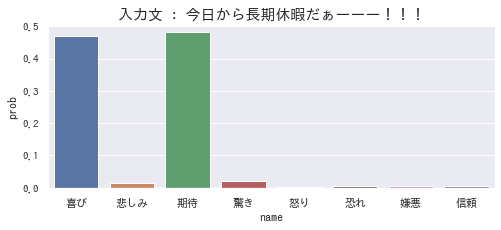

In [15]:
# https://www.delftstack.com/ja/howto/numpy/numpy-softmax/
def np_softmax(x):
    f_x = np.exp(x) / np.sum(np.exp(x))
    return f_x

def analyze_emotion(text, show_fig=False, ret_prob=False):
    # 推論モードを有効か
    model.eval()

    # 入力データ変換 + 推論
    tokens = tokenizer(text, truncation=True, return_tensors="pt")
    tokens.to(model.device)
    preds = model(**tokens)
    prob = np_softmax(preds.logits.cpu().detach().numpy()[0])
    out_dict = {n: p for n, p in zip(emotion_names_jp, prob)}

    # 棒グラフを描画
    if show_fig:
        plt.figure(figsize=(8, 3))
        df = pd.DataFrame(out_dict.items(), columns=['name', 'prob'])
        sns.barplot(x='name', y='prob', data=df)
        plt.title('入力文 : ' + text, fontsize=15)

    if ret_prob:
        return out_dict

# 動作確認
analyze_emotion('今日から長期休暇だぁーーー！！！', show_fig=True)

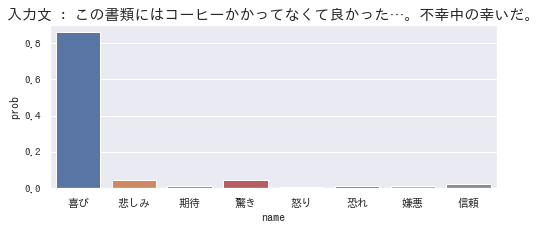

In [16]:
analyze_emotion('この書類にはコーヒーかかってなくて良かった…。不幸中の幸いだ。', show_fig=True)

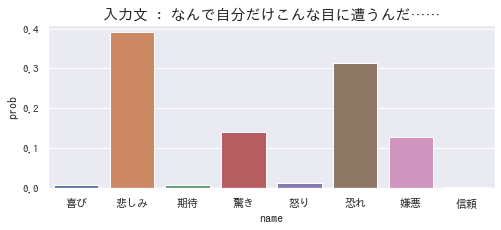

In [17]:
analyze_emotion('なんで自分だけこんな目に遭うんだ……', show_fig=True)

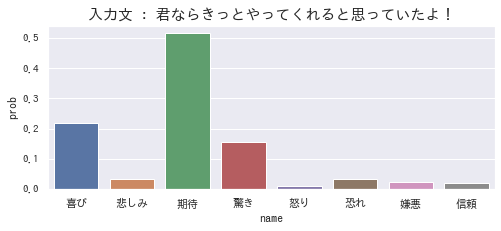

In [18]:
analyze_emotion('君ならきっとやってくれると思っていたよ！', show_fig=True)

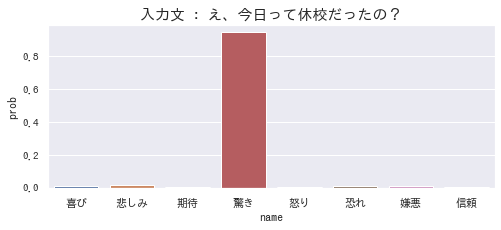

In [19]:
analyze_emotion('え、今日って休校だったの？', show_fig=True)

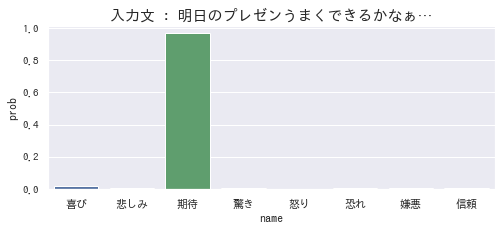

In [20]:
analyze_emotion('明日のプレゼンうまくできるかなぁ…', show_fig=True)

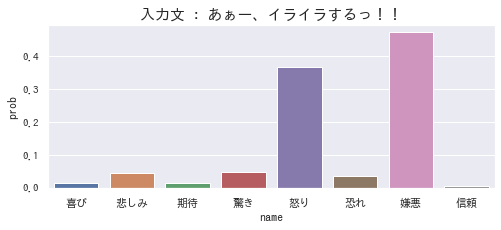

In [21]:
analyze_emotion('あぁー、イライラするっ！！', show_fig=True)